# Lab Report- Estimating $\lambda$ and $\mu$

## Overview

In this report, we perform simulations on the Stochastic Flow Queue Model as explored in Yu Shao's Master's thesis. We consider a two state model. Consider an ON-OFF fluid system, where state $S_1$ is the recovery state with buffer fluiding rate $r_1 - C$ and $S_2$ is the attacking state with buffer fluing rate $r_2 - C$. Suppose $\lambda$ is the chanding rate from state $1$ to state $2$ and $\mu$ is the changing rate from state $2$ to state $1$. The state of system is hidden from our observation. The only observable data are that from the network link in the real-time buffer conetnt $Q(t)$.  



Following are the variables involved:

| Parameter| Meaning |
| --- | --- | 
| $t$ | Time |
| $Q(t)$ | Buffer Content at time t |
| $C$ | Limited Maximum Capacity of the processor |
| $r_1$ | Rate of job submissions in State 1 |
| $r_2$ | Rate of job submissions in State 2 |
| $\lambda$ | Parameter governing state transition from State 1 to State 2|
| $\mu$ | Parameter governing state transition from State 2 to State 1 |


## Simulation

In this section, we try to simulate the $Q(t)$ values by changing the system state with time intervals, the length of which follows exponential distribution with parameters $\lambda$ and $\mu$. In a state at time $t$, the variation of $Q(t)$ follows the equation 
$$
\frac{dQ(t)}{dt} = r_i - C, Q(t) \geq 0.
$$

In the following demonstration, we use $dt = 0.1$s with $t$ from $0$ to $200$, $r_1 -C = -1$, $r_2 - C = 4$, $\lambda = 1.3$ and $\mu = 0.4$.

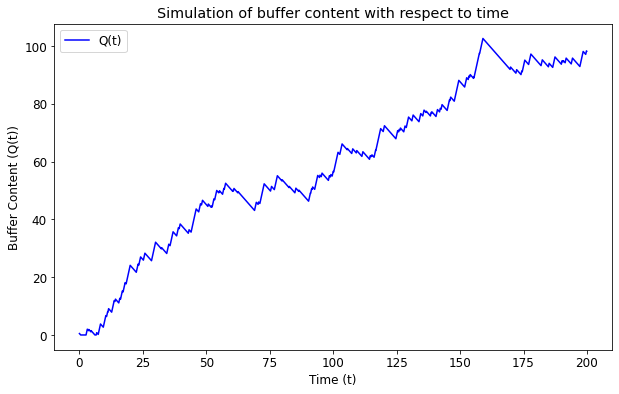

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib inline

#Transition Matrix P 
lmb = 1.3; rate_1 = -1
mu = 0.4; rate_2 = 4
P = np.array((lmb, 1 - lmb, 1 - mu, mu))
P.resize(2,2)
dt = 0.1


#function to generate the next interval length
def switchtime(l):
    return np.random.exponential(scale = l) 

#time vector storing t values in the range [0,200] with interval length dt
time = [x*dt for x in range(math.floor(200/dt))]

#initialize the Qt vector which stores the buffer content values (Q(t)) to all zeros
Qt = [0]*(math.floor(200/dt))

#initial buffer content 
Qt[0] = 0.5

#a function that returns the rate of change of the buffer content according to the current state
def rate(i):
    if i == 1:
        return rate_1
    else: 
        return rate_2
    
#assume the state at t=0 is state 1 and then simulate buffer capacity at different points in time
i = 1
state = 1
switchPoint = switchtime(lmb)
while i < math.floor(200/dt):
    if switchPoint > 0:
        Qt[i] = max(Qt[i-1] + rate(state) * dt, 0)
        switchPoint = switchPoint - dt
        i = i + 1
    else:
        if state == 1: #switch to state 2
            state = 2
            switchPoint = switchtime(mu)
        else: #switch to state 1
            state = 1
            switchPoint = switchtime(lmb)
            
#plot the simulated buffer content
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, Qt, color='b', label='Q(t)')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Buffer Content (Q(t))')
ax.set_title('Simulation of buffer content with respect to time')
ax.legend(loc='upper left');

## Estimation of $\lambda$ and $\mu$ using Fuzzy Clustering

Suppose we have $Q(t)$ values available from either a simulation as in the previous section or from the real world. We can use these data to estimate the $\lambda$ and $\mu$. 

We examine the $\frac{dQ(t)}{dt}$ values and obtain the time intervals during which the system is in a particular state. Having known these time intervals, we can obtain the lengths of these time intervals. The lengths can be seen as samples from an exponential distribution governed by either $\lambda$ or $\mu$ depending on the state in which the system is. In this section, we demonstrate how the Fuzzy Clustering algorithm can be used to estimate $\lambda$ and $\mu$. 

The Fuzzy $2-$Means Clustering algorithm is a soft clustering iterative algorithm. In the $n + 1$st iteration, each of the $N$ data points is weighed in proportion to it's likelihood of falling under one distribution over the other. Suppose we are looking at the $i$th data point and $\lambda_n$ and $\mu_n$ are our estimates of parameters from the previous iteration. We calculate $$w_{i\lambda} = \frac{p_{\lambda_n}(i)}{p_{\lambda_n}(i) + p_{\mu_n}(i)}.$$

Here, $p_{\lambda_n}(i)$ is the value of the probability density function with parameter $\lambda_n$ evaluated at $i$

We let $w_{i\mu} = 1 - w_{i\lambda}$. Having computed the weights for each data point, we estimate $\lambda_{n + 1}$ using the MLE for exponential parameters with each data point weighed according to its $w_{i\lambda}$ value. We calculate $\mu_{n + 1}$ accordingly. 

In the following demonstration, we use $N = 1000$, $\lambda = 1.3$, and $\mu = 0.4$. We use the initial values $\lambda_0 = 1$, and $\mu_0 = 0.7$. With a loerance of $1e-4$, the algorithm converges to $1.26$ and $0.38$ in the experimental trial. 



In [2]:
#We use soft-clustering to cluster our data points

#a function that returns the likelihood of a point belonging to each of the two distributions 
def pdf_based_weight(l_i, m_i, point):
    pl_i = l_i * np.exp(-l_i * point)
    pm_i = m_i * np.exp(-m_i * point)
    p_i = pl_i + pm_i
    return (pl_i / p_i, pm_i / p_i)


#initial point (l, m)
def get_estimates(l, m, data):
    tol = 1
    weights = []
    while tol > 0.01:
        for i in range(data.size):
            weights.append(pdf_based_weight(l, m, data[i]))
        weights = np.array(weights)
        del_l = l
        del_m = m
        l = (1 / np.average(data, weights = weights[:,0]) - l / (data.size - 1))
        m = (1 / np.average(data, weights = weights[:,1]) - m / (data.size - 1))
        del_l = l - del_l
        del_m = m - del_m
        tol = np.sqrt(del_l**2 + del_m**2)
        weights = []
    return (min(1/l, 1/m), max(1/l, 1/m))


## Experimental Trials 

### Analyzing the algorithm performance

In this section, we test the performance of our algorithm with varying ($\lambda$, $\mu$) values and varying initial guesses ($\lambda_0$, $\mu_0$). We also assume that we have the interval lengths.

Our $\lambda$'s and $\mu$'s belong to the set $\{0.1, 0.2,\dots,0.9\}$. We test each $(\lambda, \mu)$ pair with the following ($\lambda_0$, $\mu_0$) values: $(0.1, 0.9), (0.3, 0.7), (0.4, 0.5), (0.2, 0.7)$ and $(0.4, 0.9)$. 

In [3]:
#a list of values to check the algorithm performace on 
true_values = []
for i in range(1,10):
    for j in range(i+1,10):
        true_values.append((0.1*i, 0.1*j))

#randomly selected initial points
initial_points = [(0.1,0.9), (0.3,0.7), (0.4,0.5), (0.2,0.7), (0.4,0.9)]

In [4]:
np.seterr(divide='ignore', invalid='ignore')
results = []

#use the lmb and mu values to simulate interval lengths
def generate_data(lmb, mu):
    data_l = np.random.exponential(lmb, (5000,1))
    data_m = np.random.exponential(mu, (5000,1))
    data = np.vstack((data_l, data_m))
    return data

for lmb, mu in true_values:
    data = generate_data(lmb, mu)
    for l,m in initial_points:
        est_l, est_m = get_estimates(1/l,1/m, data)
        est_l = round(est_l,4)
        est_m = round(est_m,4)
        results.append((est_l, est_m))

results = np.array(results)
np.reshape(results,(36,5,2));

In [5]:
#Now we create a dataframe of results
data = np.zeros((36,5), dtype=(float,2))
data_stitched = np.zeros((36,5), dtype=object)
for i in range(36):
    for j in range(5):
        l,m = results[i * 5 + j]
        data[i,j] = [l,m]
        data_stitched[i,j] = str("(" + str(l) + "," + str(m) + ")") 

import pandas as pd
true_values_index = [str("(" + str(round(l,2)) + "," + str(round(m,2)) + ")") for l,m in true_values]
df = pd.DataFrame(data_stitched, columns=initial_points, index=true_values_index)

In [6]:
data_copy = data.copy();
data_error = np.zeros((36,5,2))
data_error_stitched = np.zeros((36,5), dtype=object)
for i in range(36):
    for j in range(5):
        l,m = data_copy[i,j]
        data_error[i,j,0] = round(abs(l-true_values[i][0]),3)
        data_error[i,j,1] = round(abs(m-true_values[i][1]),3)
        data_error_stitched[i,j] = str("(" + str(data_error[i,j,0]) + "," + str(data_error[i,j,1]) + ")")
#Now we store the results in a csv file
df_error = pd.DataFrame(data_error_stitched, columns=initial_points, index=true_values_index)

In [7]:
df.to_csv("results.csv")
df.to_latex("results.lex")
df_error.to_csv("errors.csv")
df_error.to_latex("errors.lex")

### Demonstration of algorithm application

In this section, we demonstrate the complete process of estimating $\lambda, \mu$ starting from the buffer content readings $Q(t)$. 

We consider two types of buffer content readings. First reading is from a simulation in which the buffer is initially empty. The second reading is from a simulation in which the buffer is not empty initially. 

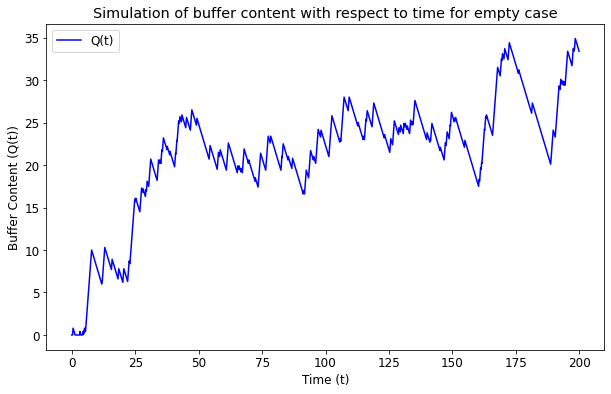

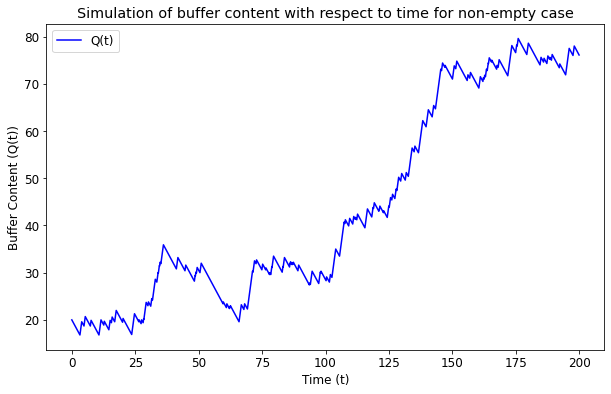

In [17]:
#Simulation of Q(t) values. 

lmb = 1.3; rate_1 = -1
mu = 0.4; rate_2 = 4
dt = 0.1

def switchtime(l):
    return np.random.exponential(scale = l) 

time = [x*dt for x in range(math.floor(200/dt))]

def rate(i):
    if i == 1:
        return rate_1
    else: 
        return rate_2

#Simulation of Q(t) values when the buffer is initially empty. Values stored in array Qt.

i = 1
state = 1
switchPoint = switchtime(lmb)
Qt = [0]*(math.floor(200/dt))
Qt[0] = 0
while i < math.floor(200/dt):
    if switchPoint > 0:
        Qt[i] = max(Qt[i-1] + rate(state) * dt, 0)
        switchPoint = switchPoint - dt
        i = i + 1
    else:
        if state == 1: #switch to state 2
            state = 2
            switchPoint = switchtime(mu)
        else: #switch to state 1
            state = 1
            switchPoint = switchtime(lmb)

#Simulation of Q(t) values when the buffer is not initially empty. Values stored in array Qt_e. 

i = 1
state = 1
switchPoint = switchtime(lmb)
Qt_e = [0]*(math.floor(200/dt))
Qt_e[0] = 20 #non-zero initial buffer content
while i < math.floor(200/dt):
    if switchPoint > 0:
        Qt_e[i] = max(Qt_e[i-1] + rate(state) * dt, 0)
        switchPoint = switchPoint - dt
        i = i + 1
    else:
        if state == 1: #switch to state 2
            state = 2
            switchPoint = switchtime(mu)
        else: #switch to state 1
            state = 1
            switchPoint = switchtime(lmb)
            
#Plot Q(t) values for both cases

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, Qt, color='b', label='Q(t)')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Buffer Content (Q(t))')
ax.set_title('Simulation of buffer content with respect to time for empty case')
ax.legend(loc='upper left');

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, Qt_e, color='b', label='Q(t)')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Buffer Content (Q(t))')
ax.set_title('Simulation of buffer content with respect to time for non-empty case')
ax.legend(loc='upper left');


Having obtained the two readings, we deduce the interval lengths for both cases. 

In [59]:
#a function to deduce interval lengths from buffer content reading
def deduce_interval_lengths(Qt, dt):
    n = len(Qt)
    up = [0]*n
    for i in range(n - 1):
        up[i] = bool( (Qt[i+1] - Qt[i]) > 0 )
    up[n - 1] = up[n - 2]
    up_length = 0;
    down_length = 0;
    data = []
    for i in range(n - 1):
        if (up[i] and up[i+1]):
            up_length = up_length + dt
        if (not up[i] and not up[i+1]):
            down_length = down_length + dt
        if (up[i] and not up[i+1]):
            data.append(up_length + dt)
            up_length = 0
        if (not up[i] and up[i+1]):
            data.append(down_length + dt)
            down_length = 0
    data.append(max(0, up_length, down_length))
    return np.array(data)

#interval lengths for case with empty buffer initially stored in data_1 array
data_1 = deduce_interval_lengths(Qt, dt)

#interval lengths for case with non-empty buffer initially stored in data_2 array
data_2 = deduce_interval_lengths(Qt_e, dt)


Having obtained the interval lengths, we can use the algorithm developed to find the $\lambda, \mu$ estimates. Remember that the buffer content was simulated using a $\lambda$ value of $1.3$ and a $\mu$ value of $0.4$.

In [62]:
#Estimates generated for Case 1
l, u = get_estimates(0.6, 0.9, data_1)
print("Our estimate for lambda, mu in the empty case is (" + str(l) + "," + str(u) + ").")

#Estimates generated for Case 2
l, u = get_estimates(0.6, 0.9, data_2)
print("Our estimate for lambda, mu in the non-empty case is (" + str(l) + "," + str(u) + ").")

Our estimate for lambda, mu in the empty case is (0.41193734919944897,1.4324757397369745).
Our estimate for lambda, mu in the non-empty case is (0.5655612982345057,1.3069553723217473).


## W1 and W2 simulation / computation

In [2]:
from mpmath import *
import math
import scipy.integrate as integrate
import numpy as np 

def double_factorial(n):
     if n <= 0:
        return 1
     else:
        return n * doublefactorial(n-2)
    
    
#only for m = 1
def BI(n, scenario='o'):
    # n - Bessel Function type
    # senario - 'o' for original , 'p' for power series , 'm' for asymptotic
    # series
    # m - orders used for approximation

    # Combination of 1st order P.S and A.S
    if (scenario == 'o'):
        Bessel = lambda t: besseli(n, t)
        return Bessel
    
    if (scenario == 'p'):
        I_PS = lambda t, k: ((t / 2) ** n) * (1 / (gamma(k + 1) * gamma(k + n + 1))) * ((t / 2) ** (2 * k))
        B = lambda t: I_PS(t, 0) + I_PS(t, 1) 
        Bessel = lambda t: B(t)
        return Bessel
    
    if (scenario == 'a'):
        I_AS = lambda t,k: (1 / (2 * pi * t)) ** (1 / 2) * math.exp(t) * (((-1) ** k) * (n ** (2 * k)) / ((double_factorial(2 * k) * (t ** (2 * k)))))
        B = lambda t: I_AS(t, 0) + I_AS(t, 1)
        Bessel = lambda t: B(t)
        return Bessel
    
    if (scenario == 'c'):
        B = lambda t: besseli(n, t)    
        I_AS = lambda t, k: (1 / (2 * pi * t)) ** (1 / 2) * math.exp(t) * (((-1) ** k) * (n ** (2 * k)) / ((double_factorial(2 * k) * (t ** (2 * k)))))
        B_AS = lambda t: I_AS(t, 0) + I_AS(t, 1)
        I_PS = lambda t, k: ((t / 2) ** n) * (1 / (gamma(k + 1) * gamma(k + n + 1)) * (t / 2) ** (2 * k))
        B_PS = lambda t: I_PS(t, 0) + I_PS(t, 1)
        
        Bessel = lambda t: (abs(B_AS(t) - B(t)) < abs(B_PS(t) - B(t))) * B_AS(t) + (abs(B_AS(t) - B(t)) >= abs(B_PS(t) - B(t))) * B_PS(t)
        return Bessel
    

    Bessel = 0

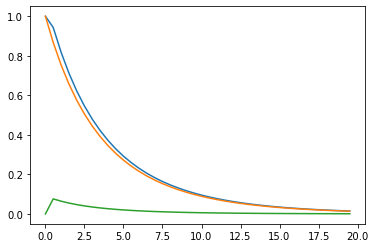

In [3]:
#order = 1 only supported
def FQ(lam , mu , r0 , r1 , x , Senario='o' , Order=1 , t_n=20 , dt=0.5):
    
    # constants
    a = ((lam * r1) - (mu * r0)) / (r1 - r0)
    b = (-1/2) * ((1/r0) - (1/r1))
    alpha = ( -4 * lam * mu * r0 * r1 / ( (r1 - r0)**2 ) ) ** (1/2)
    
    # lambda
    K = lambda t: (( t + 2 * b * x ) / t ) ** (1/2)
    
    I_0 = BI (0 , Senario) 
    I_1 = BI (1 , Senario) 
    I_2 = BI (2 , Senario) 
    
    Convol_left = lambda t: math.exp( (lam + mu) * t )
    
    g = lambda t: (1/2) * alpha * math.exp(-1 * a * t) * ( K(t) - (1 / K(t)) ) * I_1(alpha * K(t) * t)
    Convol_g = lambda t: Convol_left(t) * g(t)
    Integral_g_1 = lambda t: integrate.quad(g, 0, t)[0]
    Integral_g_2 = lambda t: -1 * math.exp( -1 * (lam + mu) * (t - x/r1) ) * integrate.quad(Convol_g, 0, t)[0]
    Integral_g = lambda t: 1 - math.exp( -1 * (lam + mu) * (t - x/r1) ) + Integral_g_1(t) + Integral_g_2(t)
    
    F_1_first = lambda t: ( lam /( lam + mu ) ) * (1 - math.exp ( -1 * ( lam + mu ) * t ) )
    F_1_second = lambda t: -1 * ( lam /( lam + mu ) ) * math.exp( -1 * mu * x / r1 ) * Integral_g(t)
    

    F_1 = []
    vec = [i for i in range(0, round(t_n/dt))]
    vec = [i/2 for i in vec]
    for t in vec:
        value = F_1_first(t)
        if t > x/r1:
            value += F_1_second(t)
        F_1.append(value)
        
    
    h = lambda t: ( (lam * mu * r1) / (r1 - r0) ) * math.exp( -1 * a * t ) * ( I_0(alpha * K(t) * t ) - ( K(t)**(-2) ) * I_2( alpha * K(t) * t ) )
    Convol_h = lambda t: Convol_left(t) * h(t)
    Integral_h_1 = lambda t: integrate.quad(h, 0, t)[0]
    Integral_h_2 = lambda t: -1 * math.exp( -1 * ( lam + mu ) * ( t - x / r1 ) ) * integrate.quad( Convol_h, 0 , t )[0]
    
    F_0_first = lambda t: ( mu /( lam + mu ) + lam /( lam + mu ) * math.exp( -1 * ( lam + mu ) * t ) )
    F_0_second = lambda t: -1 * ( 1/( lam + mu ) ) * math.exp ( -1 * mu * x / r1 ) * ( Integral_h_1(t) + Integral_h_2(t) )
    
    F_0 = []
    for t in vec:
        value = F_0_first(t)
        if t > x/r1:
            value += F_0_second(t)
        F_0.append(value)
        
    W = np.array(F_0) + np.array(F_1) 
    
    return W, F_0, F_1

import matplotlib.pyplot as plt
W, F0, F1 = FQ(0.4, 1.3, -1, 20, 5)
vec = [i for i in range(0, round(20/0.5))]
vec = [i/2 for i in vec]
plt.plot(vec, W)
plt.plot(vec, F0)
plt.plot(vec, F1)